In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from plotly import tools, subplots
import plotly.offline as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
sns.set_style("whitegrid")
%matplotlib inline

In [3]:
import plotly.express as px

In [4]:
building_path = os.path.join(os.path.dirname("ashrae.ipynb"), "data/building_metadata.csv")
train_path = os.path.join(os.path.dirname("ashrae.ipynb"), "data/train.csv")
test_path = os.path.join(os.path.dirname("ashrae.ipynb"), "data/test.csv")
weather_test_path = os.path.join(os.path.dirname("ashrae.ipynb"), "data/weather_test.csv")
weather_train_path = os.path.join(os.path.dirname("ashrae.ipynb"), "data/weather_train.csv")

building_meta = pd.read_csv(building_path)
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
weather_test = pd.read_csv(weather_test_path)
weather_train = pd.read_csv(weather_train_path)

In [5]:
train["timestamp"] = pd.to_datetime(train["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [17]:
print('shape of train: ', train.shape)
print('shape of weather_train: ', weather_train.shape)
print('shape of weather_test: ', weather_test.shape)
print('shape of building_meta: ', building_meta.shape)
print('shape of test: ', test.shape)

shape of train:  (20216100, 6)
shape of weather_train:  (139773, 12)
shape of weather_test:  (277243, 9)
shape of building_meta:  (1449, 6)
shape of test:  (41697600, 4)


In [6]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)
building_meta = reduce_mem_usage(building_meta)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [30]:
train.columns
#meter: {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

Index(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype='object')

In [37]:
pd.options.display.float_format = '{:,.2f}'.format
train.groupby('meter')['meter_reading'].describe().transpose()

meter,0,1,2,3
count,"12,060,910.00","4,182,440.00","2,708,713.00","1,264,037.00"
mean,170.83,633.36,"13,882.19",385.87
std,380.83,"7,988.21","418,313.50","2,508.17"
min,0.00,0.00,0.00,0.00
25%,19.50,11.33,45.75,0.00
50%,62.83,120.49,257.81,39.62
75%,170.07,464.31,"1,035.32",241.28
max,"79,769.00","880,374.00","21,904,700.00","160,187.00"


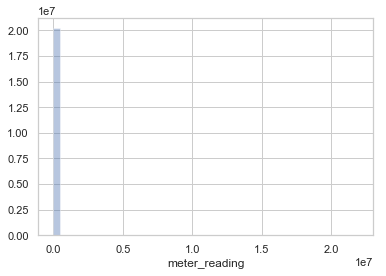

In [248]:
sns.distplot(train['meter_reading'],kde=False)

In [6]:
train_building = pd.merge(train, building_meta, how='inner', on='building_id')

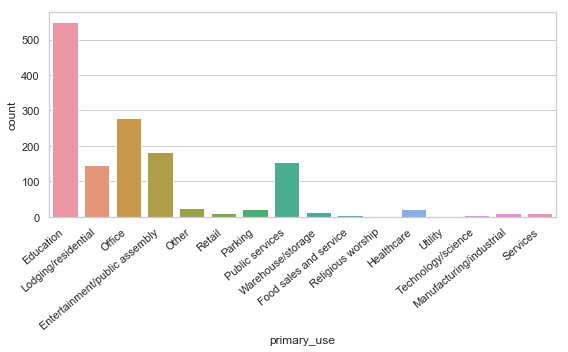

In [254]:
plt.figure(figsize=(8,5))
ax = sns.countplot(building_meta.primary_use)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [110]:
train_building.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count'],
      dtype='object')

In [113]:
train_building_corr = train_building.drop(['building_id','timestamp','site_id'],axis=1)

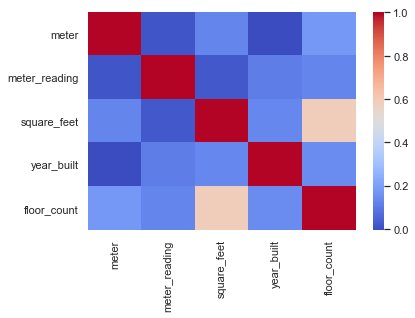

In [115]:
sns.heatmap(train_building_corr.corr(), cmap='coolwarm')

In [123]:
train_building_frac = train_building.sample(frac=0.1)
train_building_frac.shape

(2021610, 9)

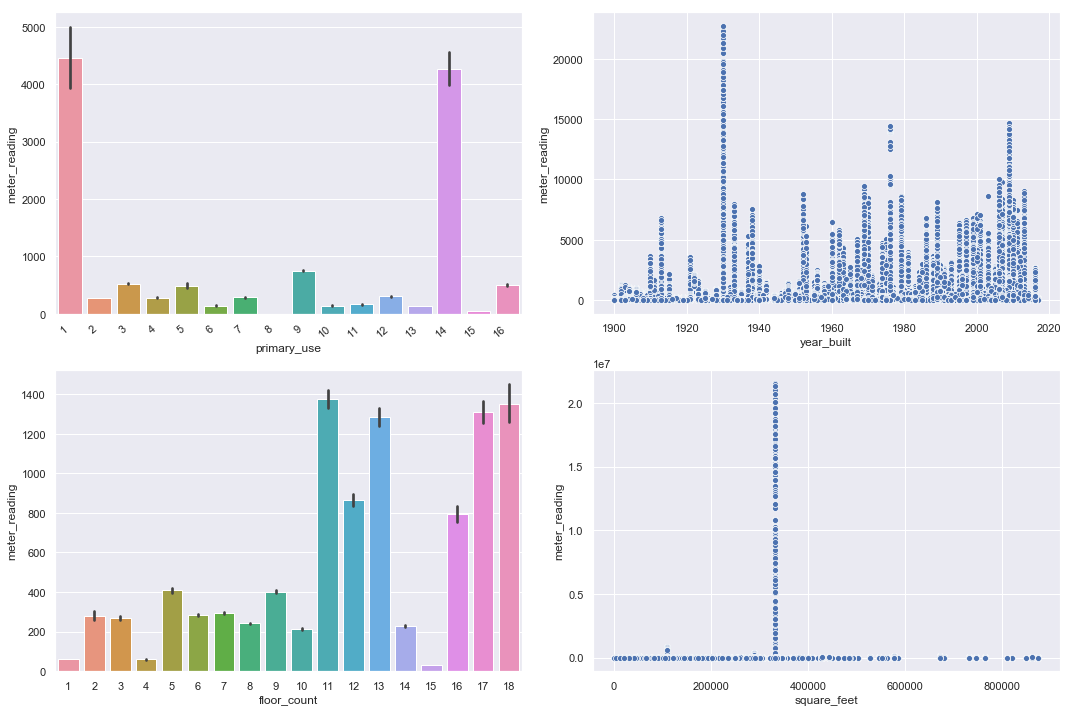

In [177]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))

sns.barplot(x='primary_use', y='meter_reading', data=train_building_frac, ax=axs[0,0])
axs[0,0].set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

sns.scatterplot(x='year_built', y='meter_reading', data=train_building_frac, ax=axs[0,1])

sns.barplot(x='floor_count', y='meter_reading', data=train_building_frac, ax=axs[1,0])
axs[1,0].set_xticklabels(list(range(1,27)))

sns.scatterplot(x='square_feet', y='meter_reading', data=train_building_frac, ax=axs[1,1])

plt.tight_layout()

In [7]:
train['Month'] = train['timestamp'].dt.month
train['Day'] = train['timestamp'].dt.day
date_pivot = train.pivot_table(index='Day', columns='Month', values='meter_reading')

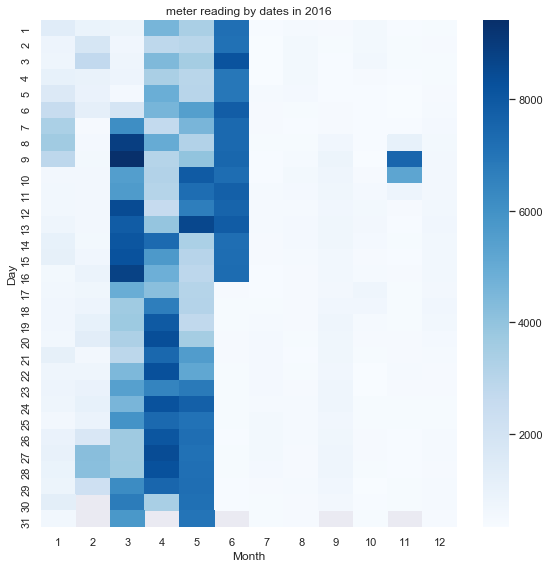

In [201]:
plt.figure(figsize=(8,8))
sns.heatmap(date_pivot, cmap = 'Blues')
plt.title('meter reading by dates in 2016')
plt.tight_layout()

In [8]:
weather_train["timestamp"] = pd.to_datetime(train["timestamp"], format='%Y-%m-%d %H:%M:%S')
weather_train['Month'] = weather_train['timestamp'].dt.month
weather_train['Day'] = weather_train['timestamp'].dt.day
weather_train['Time'] = weather_train['timestamp'].dt.time

In [9]:
weather_train['type'] = 'train'
weather_test['type'] = 'test'
weather_meta = pd.concat([weather_train, weather_test], axis=0, sort=True)

In [225]:
weather_meta.columns

Index(['Day', 'Month', 'Time', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'site_id',
       'timestamp', 'type', 'wind_direction', 'wind_speed'],
      dtype='object')

In [259]:
def plot_dist(column, ax):
    sns.distplot(weather_train[column].dropna(), color='seagreen', ax=ax).set_title(column, fontsize=16)
    sns.distplot(weather_test[column].dropna(), color='mediumorchid', ax=ax).set_title(column, fontsize=16)
    plt.xlabel(column, fontsize=15)
    ax.legend(['train', 'test'])

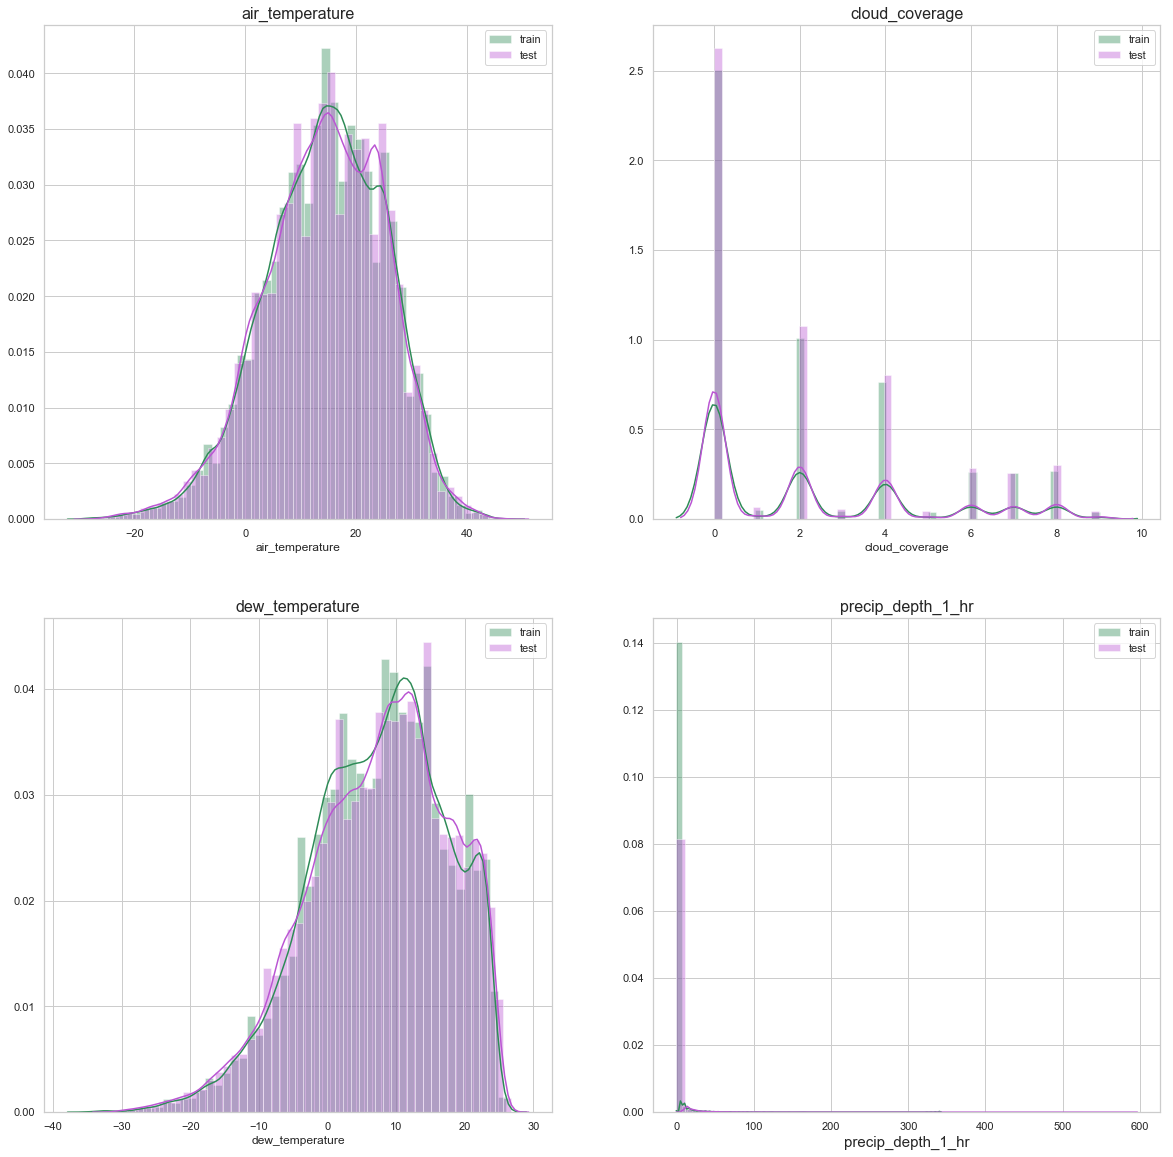

In [263]:
fig, axs = plt.subplots(2, 2, figsize=(20,20))

plot_dist('air_temperature', axs[0,0])
plot_dist('cloud_coverage', axs[0,1])
plot_dist('dew_temperature', axs[1,0])
plot_dist('precip_depth_1_hr', axs[1,1])

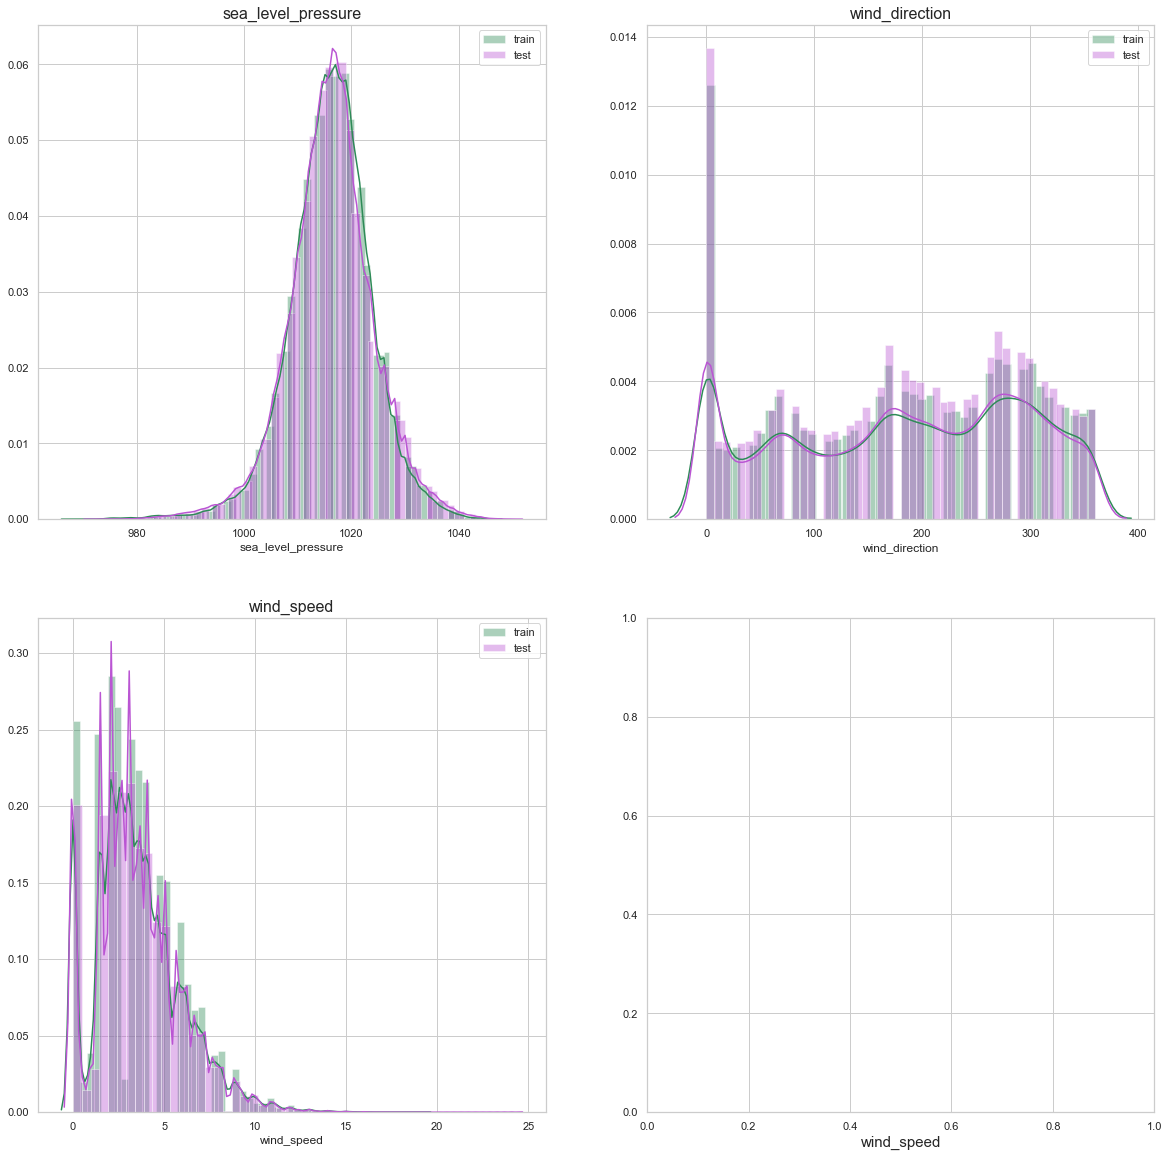

In [267]:
fig, axs = plt.subplots(2, 2, figsize=(20,20))
plot_dist('sea_level_pressure', axs[0,0])
plot_dist('wind_direction', axs[0,1])
plot_dist('wind_speed', axs[1,0])

In [16]:
train['meter'] = pd.Categorical(train['meter']).rename_categories({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})

In [17]:
train_group = train.copy()
train_group.drop(['Month','Day'], axis=1, inplace=True)
train_group['date'] = train_group['timestamp'].dt.date
train_group = train_group.groupby(['date', 'building_id', 'meter']).sum()

In [18]:
train_group_agg = train_group.groupby(['date', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])
train_group_agg = train_group_agg.reset_index()
level_0 = train_group_agg.columns.droplevel(0)
level_1 = train_group_agg.columns.droplevel(1)
level_0 = ['' if x == '' else '-' + x for x in level_0]
train_group_agg.columns = level_1 + level_0
train_group_agg.rename_axis(None, axis=1)
train_group_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max
0,2016-01-01,electricity,4.219648e+06,3037.903076,"(2016-01-01, 803, electricity)",1.160372e+05
1,2016-01-01,chilledwater,1.412169e+06,3090.084961,"(2016-01-01, 1289, chilledwater)",1.042116e+05
2,2016-01-01,steam,6.873201e+07,218891.734375,"(2016-01-01, 1099, steam)",5.095080e+07
3,2016-01-01,hotwater,1.609989e+06,11180.481445,"(2016-01-01, 1331, hotwater)",2.198245e+05
4,2016-01-02,electricity,4.288951e+06,3085.576416,"(2016-01-02, 803, electricity)",1.157768e+05


In [23]:
train_group_agg['building_id_max'] = [x[1] for x in train_group_agg['meter_reading-idxmax']]

In [31]:
electricity = train_group_agg[train_group_agg['meter']=='electricity'].copy()
electricity['building_id_max'] = pd.Categorical(electricity['building_id_max'])
electricity_graph = px.scatter(electricity, x='date', y='meter_reading-max', color='building_id_max')
electricity_graph.update_layout(title='Max electricity consumption per day')

In [32]:
chilledwater = train_group_agg[train_group_agg['meter']=='chilledwater'].copy()
chilledwater['building_id_max'] = pd.Categorical(chilledwater['building_id_max'])
px.scatter(chilledwsteater, x='date', y='meter_reading-max', color='building_id_max')

In [33]:
steam = train_group_agg[train_group_agg['meter']=='steam'].copy()
steam['building_id_max'] = pd.Categorical(steam['building_id_max'])
px.scatter(steam, x='date', y='meter_reading-max', color='building_id_max')

In [34]:
hotwater = train_group_agg[train_group_agg['meter']=='hotwater'].copy()
hotwater['building_id_max'] = pd.Categorical(hotwater['building_id_max'])
px.scatter(hotwater, x='date', y='meter_reading-max', color='building_id_max')

In [65]:
print('**max building for electricity**')
print(train_building[train_building['building_id'] == 799].iloc[0][['building_id','site_id','primary_use','square_feet','year_built','floor_count']])
print('-----------------------------------------------')
print('**max building for chilled water**')
print(train_building[train_building['building_id'] == 778].iloc[0][['building_id','site_id','primary_use','square_feet','year_built','floor_count']])
print('-----------------------------------------------')
print('**max building for steam**')
print(train_building[train_building['building_id'] == 1099].iloc[0][['building_id','site_id','primary_use','square_feet','year_built','floor_count']])
print('-----------------------------------------------')
print('**max building for hot water**')
print(train_building[train_building['building_id'] == 1021].iloc[0][['building_id','site_id','primary_use','square_feet','year_built','floor_count']])

**max building for electricity**
building_id          799
site_id                7
primary_use    Education
square_feet       527431
year_built          1976
floor_count           26
Name: 8855687, dtype: object
-----------------------------------------------
**max building for chilled water**
building_id                              778
site_id                                    6
primary_use    Entertainment/public assembly
square_feet                           108339
year_built                               NaN
floor_count                              NaN
Name: 8499352, dtype: object
-----------------------------------------------
**max building for steam**
building_id         1099
site_id               13
primary_use    Education
square_feet       332884
year_built           NaN
floor_count          NaN
Name: 13603751, dtype: object
-----------------------------------------------
**max building for hot water**
building_id                             1021
site_id                    

In [21]:
total = building_meta.isnull().sum().sort_values(ascending = False)
percent = (building_meta.isnull().sum()/building_meta.isnull().count()*100).sort_values(ascending = False)
missing_building_meta = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_building_meta

,Total,Percent
floor_count,1094,75.500345
year_built,774,53.416149
square_feet,0,0.000000
primary_use,0,0.000000
building_id,0,0.000000
site_id,0,0.000000


In [23]:
total = weather_test.isnull().sum().sort_values(ascending = False)
percent = (weather_test.isnull().sum()/weather_test.isnull().count()*100).sort_values(ascending = False)
missing_weather_test = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_weather_test

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

In [24]:
total = weather_train.isnull().sum().sort_values(ascending = False)
percent = (weather_train.isnull().sum()/weather_train.isnull().count()*100).sort_values(ascending = False)
missing_weather_train = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_weather_train

,Total,Percent
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
timestamp,0,0.000000
site_id,0,0.000000
